In [188]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY_START_DATE = '2010-01-01'

# TEST_START_DATE = '2020-01-01'
# TEST_END_DATE = '2021-12-31'


# EIIE_MODEL = "trained_eiie/policy_EIIE_2019-12-31_4_2024-11-24 00_06_19.pt"


TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2019-03-14'
TEST_START_DATE = '2019-03-14'
TEST_END_DATE = '2022-05-30'

TRAINED_PPO = "/model_checkpoint_3000000_steps_2018"

GRAPH_TITLE = "PPO Trained 2009-2019, Three Million Time Step Checkpoint"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (4860, 8)


# PPO On portfolio Opt

In [189]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

environment_ppo = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.22113901 0.36616164 0.24590092 0.29679398 0.29106187 0.47862137
 0.39771822 0.41120068 0.46705118 0.27993154 0.19488781 0.22099365
 0.2613022  0.21350683 0.21825326 0.17926239 0.17375067 0.24273006
 0.33545005 0.20346815 0.19601697 0.26035216 0.16446601 0.24099224
 0.27110079 0.22691895 0.18231226 0.21873344 0.16450353 0.17390636
 0.17489953 0.20824553 0.43642494 0.60797918 0.3000755  0.1959382
 0.30426579 0.36354318 0.24702352 0.32738834 0.38647347 0.53860965
 0.34259173 0.24894797 0.30978312 0.30835479 0.36212328 0.26601768
 0.27899557 0.34259173 0.22240698 0.26211062 0.26710933 0.19899557
 0.25362688 0.37885255 0.29043164 0.27922815 0.21126164 0.28777192
 0.24591123 0.25258868 0.17118661 0.20327401 0.17595367 0.13757333
 0.24900706 0.19811212 0.2017

In [190]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 

In [191]:
# from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "test": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["test"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["test"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["test"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1997162.875
Final accumulative portfolio value: 1.997162875
Maximum DrawDown: -0.28295431131514825
Sharpe ratio: 0.9490605007054883
Total commission cost: 18039.951280371635
hit end!
     ppo_opt_net_worth       Date
0          1000000.000 2019-03-14
1          1010447.875 2019-03-15
2          1015379.125 2019-03-18
3          1014210.750 2019-03-19
4          1013478.750 2019-03-20
..                 ...        ...
805        1907693.250 2022-05-23
806        1888930.250 2022-05-24
807        1902486.000 2022-05-25
808        1940599.000 2022-05-26
809        1997162.875 2022-05-27

[810 rows x 2 columns]


In [192]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2019-03-14 00:00:00')

# Porfolio Baselines

In [193]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

environment_benchmark = PortfolioOptimizationEnv(
    processed_test,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [194]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmark.reset()
agent_crp = DRLStableAgent(env = environment_benchmark)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmark)
CRP_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1456539.125
Final accumulative portfolio value: 1.456539125
Maximum DrawDown: -0.35611463497982054
Sharpe ratio: 0.564803509628535
Total commission cost: 11563.19409049733
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.011105e+06 2019-03-15
2         1.013119e+06 2019-03-18
3         1.012544e+06 2019-03-19
4         1.011011e+06 2019-03-20
..                 ...        ...
805       1.388311e+06 2022-05-23
806       1.369804e+06 2022-05-24
807       1.380550e+06 2022-05-25
808       1.416730e+06 2022-05-26
809       1.456539e+06 2022-05-27

[810 rows x 2 columns]


In [195]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmark.reset()
agent_bah = DRLStableAgent(env = environment_benchmark)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmark)
BAH_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1646122.25
Final accumulative portfolio value: 1.64612225
Maximum DrawDown: -0.3039326389441158
Sharpe ratio: 0.7174853690160153
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.011105e+06 2019-03-15
2         1.013094e+06 2019-03-18
3         1.012513e+06 2019-03-19
4         1.010969e+06 2019-03-20
..                 ...        ...
805       1.574028e+06 2022-05-23
806       1.556264e+06 2022-05-24
807       1.564211e+06 2022-05-25
808       1.598304e+06 2022-05-26
809       1.646122e+06 2022-05-27

[810 rows x 2 columns]


In [196]:
# OLMAR

OLMAR_results = {
    "test": {},
}

# OLMAR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }


environment_benchmark.reset()
agent_olmar = DRLStableAgent(env = environment_benchmark)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmark)
OLMAR_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 307024.1875
Final accumulative portfolio value: 0.3070241875
Maximum DrawDown: -0.7484294450055093
Sharpe ratio: -0.5491585148368037
Total commission cost: 483635.04468598205
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2019-03-14
1           1.011105e+06 2019-03-15
2           1.005150e+06 2019-03-18
3           1.003823e+06 2019-03-19
4           1.002713e+06 2019-03-20
..                   ...        ...
805         2.876968e+05 2022-05-23
806         2.763145e+05 2022-05-24
807         2.824702e+05 2022-05-25
808         2.955917e+05 2022-05-26
809         3.070242e+05 2022-05-27

[810 rows x 2 columns]


In [197]:
# RMR

RMR_results = {
    "test": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmark.reset()
agent_rmr = DRLStableAgent(env = environment_benchmark)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmark)
RMR_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2612499.25
Final accumulative portfolio value: 2.61249925
Maximum DrawDown: -0.3142726363753219
Sharpe ratio: 1.0532592229765454
Total commission cost: 25095.884785574162
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2019-03-14
1         1.011105e+06 2019-03-15
2         1.005150e+06 2019-03-18
3         1.003823e+06 2019-03-19
4         1.002713e+06 2019-03-20
..                 ...        ...
805       2.498495e+06 2022-05-23
806       2.450483e+06 2022-05-24
807       2.453277e+06 2022-05-25
808       2.510192e+06 2022-05-26
809       2.612499e+06 2022-05-27

[810 rows x 2 columns]


In [198]:
# BNN

BNN_results = {
    "test": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmark.reset()
agent_bnn = DRLStableAgent(env = environment_benchmark)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmark)
BNN_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2837155.0
Final accumulative portfolio value: 2.837155
Maximum DrawDown: -0.3142726199856509
Sharpe ratio: 1.1300429670795873
Total commission cost: 9204.91586491745
hit end!
     bnn_opt_net_worth       Date
0           1000000.00 2019-03-14
1           1000000.00 2019-03-15
2           1000000.00 2019-03-18
3           1000000.00 2019-03-19
4           1000000.00 2019-03-20
..                 ...        ...
805         2713347.00 2022-05-23
806         2661206.75 2022-05-24
807         2664240.50 2022-05-25
808         2726049.50 2022-05-26
809         2837155.00 2022-05-27

[810 rows x 2 columns]


In [199]:
# SCRP

HISTORY_START_DATE = TRAIN_START_DATE
HISTORY_END_DATE = TRAIN_END_DATE

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = HISTORY_END_DATE,
                     ticker_list = PORT).fetch_data()


SCRP_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

environment_benchmark.reset()
agent_scrp = DRLStableAgent(env = environment_benchmark)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmark)
SCRP_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Shape of DataFrame:  (15024, 8)
Initial portfolio value:1000000
Final portfolio value: 8610583.0
Final accumulative portfolio value: 8.610583
Maximum DrawDown: -0.4379726257207496
Sharpe ratio: 0.9551670711893592
Total commission cost: 15542.265338609694
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 3350736.25
Final accumulative portfolio value: 3.35073625
Maximum DrawDown: -0.3142724633471944
Sharpe ratio: 1.2692353222045465
Total commission cost: 0.007900675060227513
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2019-03-14
1          1.013008e+06 2019-03-15
2          1.023350e+06 2019-03-18
3          1.015240e+06 2019-03-19
4          1.024112e+06 2019-03-20
..                  ...        ...
805        3.204516e+06 2022-05-23
806        3.142938e+06 2022-05-24
807        3.146521e+06 2022-05-25
808        3.219518e+06 2022-05-26
809        3.350736e+06 2022-05-27

[810 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [200]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmark.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmark)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmark)
BCRP_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 3350736.25
Final accumulative portfolio value: 3.35073625
Maximum DrawDown: -0.3142724633471944
Sharpe ratio: 1.2692353222045465
Total commission cost: 0.0
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2019-03-14
1          1.013008e+06 2019-03-15
2          1.023350e+06 2019-03-18
3          1.015240e+06 2019-03-19
4          1.024112e+06 2019-03-20
..                  ...        ...
805        3.204516e+06 2022-05-23
806        3.142938e+06 2022-05-24
807        3.146521e+06 2022-05-25
808        3.219518e+06 2022-05-26
809        3.350736e+06 2022-05-27

[810 rows x 2 columns]


# Stock environment optimization algorithm

In [201]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_ppo_date.loc[0,'Date'],
        end = df_ppo_date.loc[len(df_ppo_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_ppo_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (809, 8)
Annual return          0.077146
Cumulative returns     0.269439
Annual volatility      0.235142
Sharpe ratio           0.434856
Calmar ratio           0.208018
Stability              0.687978
Max drawdown          -0.370862
Omega ratio            1.096573
Sortino ratio          0.595824
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.909020
Daily value at risk   -0.029219
dtype: float64
df_dji:            date           dji
0   2019-03-14  1.000000e+06
1   2019-03-15  1.005404e+06
2   2019-03-18  1.007941e+06
3   2019-03-19  1.006902e+06
4   2019-03-20  1.001390e+06
..         ...           ...
805 2022-05-23  1.239997e+06
806 2022-05-24  1.241878e+06
807 2022-05-25  1.249333e+06
808 2022-05-26  1.269439e+06
809 2022-05-27           NaN

[810 rows x 2 columns]
df_dji:                       dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06

# Compare all results

In [202]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')


# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')




print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2019-03-14  1.000000e+06
2019-03-15  1.005404e+06
2019-03-18  1.007941e+06
2019-03-19  1.006902e+06
2019-03-20  1.001390e+06
...                  ...
2022-05-23  1.239997e+06
2022-05-24  1.241878e+06
2022-05-25  1.249333e+06
2022-05-26  1.269439e+06
2022-05-27           NaN

[810 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2019-03-14        1.000000e+06       1.000000e+06   
1         1.011105e+06 2019-03-15        1.013008e+06       1.011105e+06   
2         1.013119e+06 2019-03-18        1.023350e+06       1.013094e+06   
3         1.012544e+06 2019-03-19        1.015240e+06       1.012513e+06   
4         1.011011e+06 2019-03-20        1.024112e+06       1.010969e+06   
..                 ...        ...                 ...                ...   
805       1.388311e+06 2022-05-23        3.204516e+06       1.574028e+06   
806       1.369804e+06 2022-05-24        3.

# Baseline CRP in the environment

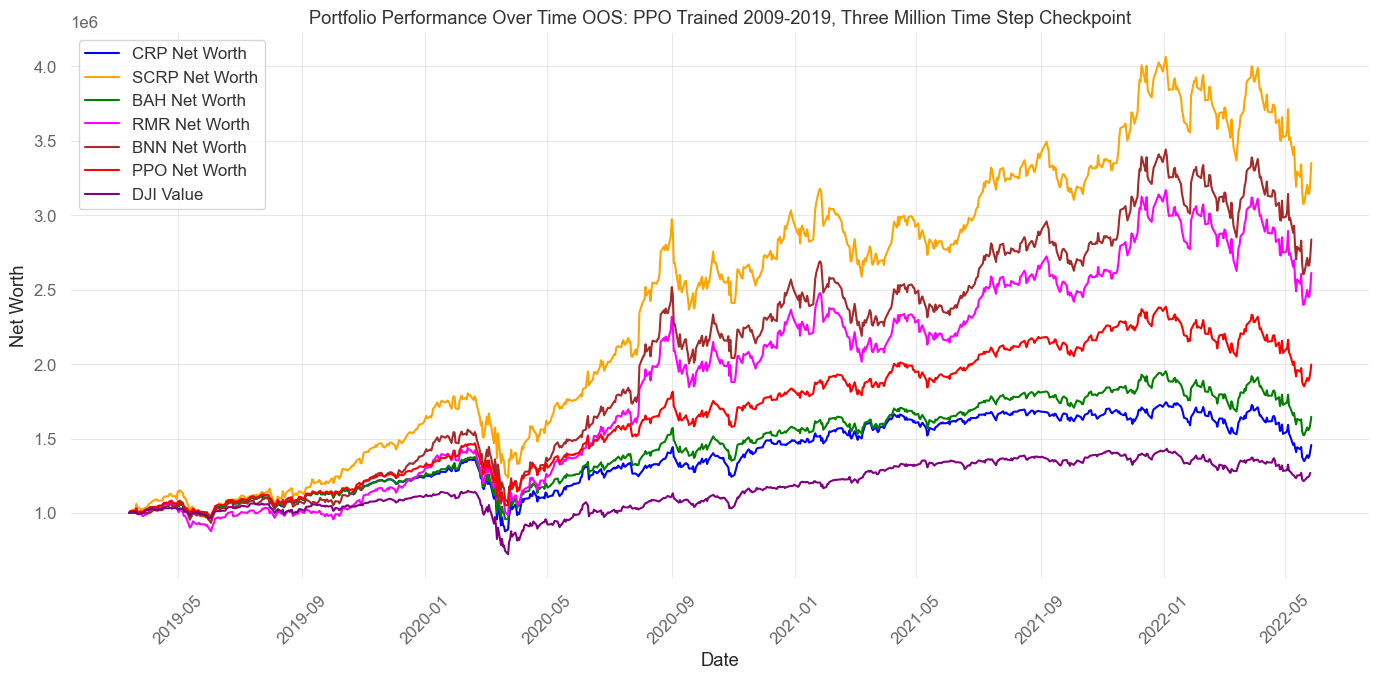

In [203]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'PPO Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}




plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Net Worth', color=color_map['PPO Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [204]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'Hist. SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 1646122.25,
 'BCRP OPT': 3350736.25,
 'BNN': 2837155.0,
 'CRP': 1456539.125,
 'Hist. SCRP': 3350736.25,
 'OLMAR': 307024.1875,
 'PPO': 1997162.875,
 'RMR': 2612499.25}


In [205]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'Hist. SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 0.6426609590461394,
 'BCRP': 1.211733323240014,
 'BNN': 1.0715567057833808,
 'CRP': 0.492259066521953,
 'Hist. SCRP': 1.211733323240014,
 'OLMAR': -0.592414593790832,
 'PPO': 0.8738203256370315,
 'RMR': 0.9947840617429169}


In [206]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'Hist. SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.3039326389441158,
 'BCRP': -0.3142724633471944,
 'BNN': -0.3142726199856509,
 'CRP': -0.35611463497982054,
 'Hist. SCRP': -0.3142724633471944,
 'OLMAR': -0.7484294450055093,
 'PPO': -0.28295431131514825,
 'RMR': -0.3142726363753219}


In [207]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'Hist. SCRP': calculate_up_days_ratio(merged_df['SCRP_opt_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'OLMAR': calculate_up_days_ratio(merged_df['OLMAR_opt_daily_return']),
    'RMR': calculate_up_days_ratio(merged_df['RMR_opt_daily_return']),
    'BNN': calculate_up_days_ratio(merged_df['BNN_opt_daily_return']),
    'PPO': calculate_up_days_ratio(merged_df['ppo_opt_daily_return']),
}

pprint.pprint(up_days_ratios)

{'BAH': 0.5673671199011124,
 'BCRP': 0.5352286773794809,
 'BNN': 0.5278121137206427,
 'CRP': 0.5500618046971569,
 'Hist. SCRP': 0.5352286773794809,
 'OLMAR': 0.4783683559950556,
 'PPO': 0.5822002472187886,
 'RMR': 0.5352286773794809}


In [208]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq      df         F   PR(>F)
Portfolio  0.000023     1.0  0.081651  0.77511
Residual   0.449431  1616.0       NaN      NaN


In [209]:
merged_df['ppo_opt_daily_return']

0           NaN
1      0.010448
2      0.004880
3     -0.001151
4     -0.000722
         ...   
805    0.030438
806   -0.009835
807    0.007176
808    0.020033
809    0.029148
Name: ppo_opt_daily_return, Length: 810, dtype: float64

In [210]:
from scipy import stats

df_ppo = merged_df['ppo_opt_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.011105
2      0.001967
3     -0.000573
4     -0.001525
5      0.014001
         ...   
805    0.033487
806   -0.011286
807    0.005106
808    0.021796
809    0.029918
Name: BAH_opt_daily_return, Length: 809, dtype: float64
t-statistic: 0.2857456346253032
p-value: 0.7751095716376776
